In [51]:
import xml.etree.ElementTree as ET
import networkx as nx
from collections import defaultdict

in_path = "../data/networks/coauthorship-network-2019_2020_2021_2022-20251222-061202.gexf"
out_path = "../data/networks/coauthorship-network-2019_2020_2021_2022-fixed.gexf"

tree = ET.parse(in_path)
root = tree.getroot()
ns_uri = root.tag.split("}")[0].strip("{") if root.tag.startswith("{") else ""
def q(tag): return f"{{{ns_uri}}}{tag}" if ns_uri else tag

# descobrir quais attr_id correspondem a age e age_range
remove_ids = set()
for attrs in root.findall(f".//{q('attributes')}"):
    for a in attrs.findall(f"{q('attribute')}"):
        title = a.attrib.get("title")
        if title in {"age", "age_range"}:
            remove_ids.add(a.attrib.get("id"))

# remover as definições desses atributos
for attrs in root.findall(f".//{q('attributes')}"):
    for a in list(attrs.findall(f"{q('attribute')}")):
        if a.attrib.get("id") in remove_ids:
            attrs.remove(a)

# remover os attvalue correspondentes em nós
for node in root.findall(f".//{q('node')}"):
    avs_parent = node.find(f"{q('attvalues')}")
    if avs_parent is None:
        continue
    for av in list(avs_parent.findall(f"{q('attvalue')}")):
        if av.attrib.get("for") in remove_ids:
            avs_parent.remove(av)

tree.write(out_path, encoding="utf-8", xml_declaration=True)
print("Salvo:", out_path)


Salvo: ../data/networks/coauthorship-network-2019_2020_2021_2022-fixed.gexf


In [52]:
gexf_path = "../data/networks/coauthorship-network-2019_2020_2021_2022-fixed.gexf"

# carregar rede
G = nx.read_gexf(gexf_path)

print(f"N nós: {G.number_of_nodes()}")
print(f"N arestas: {G.number_of_edges()}")

# tentar detectar nome do atributo do partido
party_attr_name = None
for _, data in G.nodes(data=True):
    for candidate in ["party", "siglaPartido", "partido"]:
        if candidate in data:
            party_attr_name = candidate
            break
    if party_attr_name:
        break

print(f"Atributo de partido detectado: {party_attr_name}")

# mapear nós -> partido (ou None)
party_of = {}
for n, data in G.nodes(data=True):
    partido = data.get(party_attr_name)
    party_of[n] = partido

# acumular peso por partido
peso_por_partido = defaultdict(float)

for u, v, data in G.edges(data=True):
    w = data.get("weight", 1)

    pu = party_of.get(u)
    pv = party_of.get(v)

    # conte para ambos os lados, ignorando nós sem partido
    if pu:
        peso_por_partido[pu] += w
    if pv:
        peso_por_partido[pv] += w

# ordenar do maior para o menor
resultado = sorted(peso_por_partido.items(), key=lambda x: x[1], reverse=True)

print("\n=== PESO TOTAL POR PARTIDO ===")
for partido, peso in resultado:
    print(f"{partido:>6}  {peso:,.0f}")



N nós: 637
N arestas: 45177
Atributo de partido detectado: party

=== PESO TOTAL POR PARTIDO ===
    PT  23,843
    PP  17,404
    PL  16,486
   PSD  9,941
REPUBLICANOS  9,449
   MDB  9,186
 UNIÃO  9,113
  PSDB  4,141
   PDT  3,150
   PSB  2,731
SOLIDARIEDADE  1,983
 PCdoB  1,900
  PSOL  1,472
CIDADANIA  1,425
   PSC  883
PATRIOTA  804
  PROS  751
    PV  622
AVANTE  607
  PODE  533
   PTB  464
  REDE  239
  NOVO  183


In [53]:
import pandas as pd

# =========================
# Caminhos
# =========================
PROPOSALS_PATH = "../data/proposals_info.csv"
AUTHORS_PATH = "../data/authors_info.csv"

# =========================
# Carregamento
# =========================
p = pd.read_csv(PROPOSALS_PATH)
a = pd.read_csv(AUTHORS_PATH)

# =========================
# Universo de proposições
# =========================
total_propositions = len(p)
unique_props_with_author = a["idProposicao"].nunique()

# =========================
# Contagem de autores por proposição
# =========================
authors_per_prop = (
    a.groupby("idProposicao")["idAutor"]
     .nunique()
)

props_0_authors = total_propositions - unique_props_with_author
props_1_author = (authors_per_prop == 1).sum()
props_2plus_authors = (authors_per_prop >= 2).sum()

# =========================
# Impressão clara
# =========================
print("\n===== PROPOSIÇÕES USADAS NA REDE =====\n")

print(f"Total de proposições no universo analisado: {total_propositions}")
print(f"Proposições com pelo menos 1 autor deputado: {unique_props_with_author}")
print(f"Proposições sem autor deputado: {props_0_authors}")

print("\n--- Autoria parlamentar ---")
print(f"Proposições com exatamente 1 autor: {props_1_author}")
print(f"Proposições com 2 ou mais autores (GERAM ARESTAS): {props_2plus_authors}")

print("\n--- Interpretação ---")
print(
    "• Todas as proposições acima fazem parte da análise política.\n"
    "• Apenas proposições com 2 ou mais autores geram arestas na rede de coautoria.\n"
)

# =========================
# Checagem de consistência
# =========================
check_sum = props_0_authors + props_1_author + props_2plus_authors
if check_sum != total_propositions:
    print("AVISO: soma não bate com total de proposições!")
    print(f"Soma = {check_sum}, Total = {total_propositions}")
else:
    print("Checagem OK: soma consistente com o total.")



===== PROPOSIÇÕES USADAS NA REDE =====

Total de proposições no universo analisado: 827
Proposições com pelo menos 1 autor deputado: 435
Proposições sem autor deputado: 392

--- Autoria parlamentar ---
Proposições com exatamente 1 autor: 347
Proposições com 2 ou mais autores (GERAM ARESTAS): 88

--- Interpretação ---
• Todas as proposições acima fazem parte da análise política.
• Apenas proposições com 2 ou mais autores geram arestas na rede de coautoria.

Checagem OK: soma consistente com o total.


In [94]:
import pandas as pd

# =========================
# Caminhos
# =========================
PROPOSALS_PATH = "../data/proposals_info.csv"
VOTED_MAP_PATH = "../data/proposals_voted_map.csv"

# =========================
# Carregar dados
# =========================
p = pd.read_csv(PROPOSALS_PATH)
voted = pd.read_csv(VOTED_MAP_PATH)

# normalização mínima
p["id"] = pd.to_numeric(p["id"], errors="coerce").astype("Int64")
p = p.dropna(subset=["id"]).copy()
p["id"] = p["id"].astype(int)

voted_ids = set(
    pd.to_numeric(voted["idProposicao"], errors="coerce")
      .dropna()
      .astype(int)
      .tolist()
)

# =========================
# Conjuntos lógicos
# =========================

# P_tipo: tudo que chegou ao proposals_info (já filtrado por tipo)
P_tipo = set(p["id"])

# Aprovadas (status)
P_aprovadas = set(
    p.loc[p["ultimoStatus_descricaoSituacao"] == "Transformado em Norma Jurídica", "id"]
)

# Arquivadas
P_arquivadas = set(
    p.loc[p["ultimoStatus_descricaoSituacao"] == "Arquivada", "id"]
)

# Votadas (a partir do VotesMiner, SEM filtro de divisividade)
P_votadas = voted_ids

# Interseção: Arquivadas ∩ Votadas
P_arquivadas_votadas = P_arquivadas & P_votadas

# União final
P_final = P_aprovadas | P_arquivadas_votadas

# =========================
# Impressão estruturada
# =========================
print("\n===== CONTAGEM DOS CONJUNTOS DE PROPOSIÇÕES =====\n")

print(f"|P_tipo| (tipos legislativos considerados): {len(P_tipo)}")

print("\n--- Status ---")
print(f"|Aprovadas| (Transformado em Norma Jurídica): {len(P_aprovadas)}")
print(f"|Arquivadas| (total): {len(P_arquivadas)}")

print("\n--- Votação ---")
print(f"|Votadas| (aparecem em qualquer votação): {len(P_votadas)}")
print(f"|Arquivadas ∩ Votadas|: {len(P_arquivadas_votadas)}")

print("\n--- União final ---")
print(f"|P_final| (Aprovadas ∪ (Arquivadas ∩ Votadas)): {len(P_final)}")

# =========================
# Checagem lógica
# =========================
if P_final <= P_tipo:
    print("\nChecagem OK: P_final ⊆ P_tipo")
else:
    print("\nAVISO: P_final contém elementos fora de P_tipo (inconsistência).")



===== CONTAGEM DOS CONJUNTOS DE PROPOSIÇÕES =====

|P_tipo| (tipos legislativos considerados): 827

--- Status ---
|Aprovadas| (Transformado em Norma Jurídica): 827
|Arquivadas| (total): 0

--- Votação ---
|Votadas| (aparecem em qualquer votação): 8492
|Arquivadas ∩ Votadas|: 0

--- União final ---
|P_final| (Aprovadas ∪ (Arquivadas ∩ Votadas)): 827

Checagem OK: P_final ⊆ P_tipo


In [54]:
def print_graph_summary(G: nx.Graph, weight_attr: str = "weight") -> None:

    def is_multigraph(G):
        return isinstance(G, (nx.MultiGraph, nx.MultiDiGraph))

    n = G.number_of_nodes()
    m = G.number_of_edges()

    # Densidade
    density = nx.density(G) if n > 1 else 0.0

    # Coeficiente de clusterização (médio)
    # Para grafos direcionados, average_clustering usa a versão não-direcionada (projeção) ao converter.
    try:
        clustering = nx.average_clustering(G.to_undirected() if G.is_directed() else G)
    except Exception:
        clustering = float("nan")

    # Componentes conexas: usar versão não-direcionada para DiGraph
    UG = G.to_undirected() if G.is_directed() else G
    if n == 0:
        largest_cc_pct = 0.0
        largest_cc_size = 0
    else:
        try:
            largest_cc_size = max((len(c) for c in nx.connected_components(UG)), default=0)
        except nx.NetworkXNotImplemented:
            # Caso extremo: se não der connected_components, tenta weakly para directed
            if G.is_directed():
                largest_cc_size = max((len(c) for c in nx.weakly_connected_components(G)), default=0)
            else:
                largest_cc_size = 0
        largest_cc_pct = (largest_cc_size / n * 100.0) if n > 0 else 0.0

    # Graus (considerando degree total, para DiGraph é in+out)
    degrees = dict(G.degree())
    vertices_deg_gt0 = sum(1 for d in degrees.values() if d > 0)

    if n > 0:
        min_degree = min(degrees.values())
        max_degree = max(degrees.values())
        mean_degree = sum(degrees.values()) / n
    else:
        min_degree = max_degree = mean_degree = float("nan")

    # Pesos de aresta
    weights = []
    if m > 0:
        if is_multigraph(G):
            for u, v, k, data in G.edges(keys=True, data=True):
                w = data.get(weight_attr, 1.0)
                try:
                    weights.append(float(w))
                except Exception:
                    pass
        else:
            for u, v, data in G.edges(data=True):
                w = data.get(weight_attr, 1.0)
                try:
                    weights.append(float(w))
                except Exception:
                    pass

    if len(weights) > 0:
        min_w = min(weights)
        max_w = max(weights)
        mean_w = sum(weights) / len(weights)
    else:
        min_w = max_w = mean_w = float("nan")

    # Impressão
    print(f"Densidade: {density:.6f}")
    print(f"Coeficiente de Clusterização: {clustering:.6f}")
    print(f"Tamanho da maior componente conexa (%): {largest_cc_pct:.2f}% ({largest_cc_size}/{n})")
    print(f"Vértices com grau maior que zero: {vertices_deg_gt0}/{n}")
    print(f"Menor grau: {min_degree if n>0 else 'NA'}")
    print(f"Maior grau: {max_degree if n>0 else 'NA'}")
    print(f"Grau médio: {mean_degree:.6f}" if n > 0 else "Grau médio: NA")
    print(f"Menor peso de aresta: {min_w}")
    print(f"Maior peso de aresta: {max_w}")
    print(f"Peso médio de aresta: {mean_w}")


In [55]:
print_graph_summary(G, weight_attr="weight")

Densidade: 0.223024
Coeficiente de Clusterização: 0.650210
Tamanho da maior componente conexa (%): 78.34% (499/637)
Vértices com grau maior que zero: 499/637
Menor grau: 0
Maior grau: 391
Grau médio: 141.843014
Menor peso de aresta: 1.0
Maior peso de aresta: 12.0
Peso médio de aresta: 1.3008610576178143


In [56]:
from collections import defaultdict
import pandas as pd

# 1) Detectar automaticamente o atributo de partido
party_attr_name = None
for _, data in G.nodes(data=True):
    for candidate in ["party", "siglaPartido", "partido"]:
        if candidate in data:
            party_attr_name = candidate
            break
    if party_attr_name:
        break

print("Atributo de partido detectado:", party_attr_name)

# 2) Mapear nós -> partido
party_of = {}
for n, data in G.nodes(data=True):
    partido = data.get(party_attr_name)
    party_of[n] = partido

# 3) Tamanho de cada partido (número de nós/deputados na rede)
nodes_by_party = defaultdict(set)
for n, p in party_of.items():
    if p:
        nodes_by_party[p].add(n)

party_sizes = {p: len(ns) for p, ns in nodes_by_party.items()}

# 4) Coautoria partido–partido (ponderada pelo weight da aresta)
#    Vamos construir uma matriz DIRECIONADA:
#    A->B = quanto do peso de coautoria "passa" de A para B
weight_by_party_pair = defaultdict(float)

for u, v, data in G.edges(data=True):
    w = data.get("weight", 1.0)

    pu = party_of.get(u)
    pv = party_of.get(v)

    # ignorar arestas onde algum lado não tem partido
    if pu is None or pv is None:
        continue

    # contar nos dois sentidos para poder olhar "do ponto de vista de A"
    weight_by_party_pair[(pu, pv)] += w
    if pu != pv:
        weight_by_party_pair[(pv, pu)] += w

# 5) Total de coautoria de cada partido A (somando A->qualquer B)
total_by_party = defaultdict(float)
for (pa, pb), w in weight_by_party_pair.items():
    total_by_party[pa] += w

# 6) DataFrame com matriz A coautora com B (peso e fração)
rows = []
for (pa, pb), w in weight_by_party_pair.items():
    total_pa = total_by_party[pa]
    frac = w / total_pa if total_pa > 0 else 0.0
    rows.append({
        "partido_A": pa,
        "partido_B": pb,
        "peso_AB": w,
        "frac_coautoria_de_A_para_B": frac
    })

df_party_party = pd.DataFrame(rows)

# 7) Para cada partido_A, encontrar o B com maior fração de coautoria
melhor_parceria = []

for partido_A in sorted(party_sizes.keys()):
    sub = df_party_party[df_party_party["partido_A"] == partido_A]
    if sub.empty:
        continue
    sub = sub.sort_values(
        by=["frac_coautoria_de_A_para_B", "peso_AB"],
        ascending=False
    )
    top = sub.iloc[0]
    melhor_parceria.append({
        "partido_A": partido_A,
        "tam_bancada_A": party_sizes.get(partido_A, 0),
        "partido_B_top": top["partido_B"],
        "peso_AB": top["peso_AB"],
        "frac_coautoria_de_A_para_B": top["frac_coautoria_de_A_para_B"]
    })

df_top_parceria = pd.DataFrame(melhor_parceria).sort_values(
    by="frac_coautoria_de_A_para_B",
    ascending=False
)

df_top_parceria.reset_index(drop=True, inplace=True)

print("Ranking: para cada partido A, qual B é o parceiro preferencial (normalizado pela coautoria total de A):")
df_top_parceria


Atributo de partido detectado: party
Ranking: para cada partido A, qual B é o parceiro preferencial (normalizado pela coautoria total de A):


,partido_A,tam_bancada_A,partido_B_top,peso_AB,frac_coautoria_de_A_para_B
0,PSOL,9,PT,745.0,0.537906
1,PT,63,PT,8199.0,0.524099
2,REDE,2,PT,87.0,0.367089
3,PTB,5,PL,121.0,0.261905
4,PCdoB,9,PT,454.0,0.245273
5,PL,85,PP,3551.0,0.242903
6,PSC,11,PP,209.0,0.237770
7,PP,66,PL,3551.0,0.227774
8,MDB,43,PP,1818.0,0.211346
9,SOLIDARIEDADE,9,PT,404.0,0.204868


In [57]:
def calc_total_weight(path1: str, path2: str):
    def total_weight(g):
        w = 0
        for _, _, data in g.edges(data=True):
            w += float(data.get("weight", 0))
        return w

    print("Carregando rede 1:", path1)
    G1 = nx.read_gexf(path1)

    print("Carregando rede 2:", path2)
    G2 = nx.read_gexf(path2)

    tw1 = total_weight(G1)
    tw2 = total_weight(G2)

    print("\n===== RESULTADO =====")
    print(f"Rede 1: peso total = {tw1}")
    print(f"Rede 2: peso total = {tw2}")
    print("=====================\n")

    return tw1, tw2

In [58]:
#calc_total_weight("../data/networks/covoting-2019_2020_2021_2022-20251208-051415.gexf","../data/networks/coauthorship-network-2019_2020_2021_2022-20251208-051609.gexf")

Carregando rede 1: ../data/networks/covoting-2019_2020_2021_2022-20251208-051415.gexf
Carregando rede 2: ../data/networks/coauthorship-network-2019_2020_2021_2022-20251208-051609.gexf


FileNotFoundError: [Errno 2] No such file or directory: '../data/networks/coauthorship-network-2019_2020_2021_2022-20251208-051609.gexf'

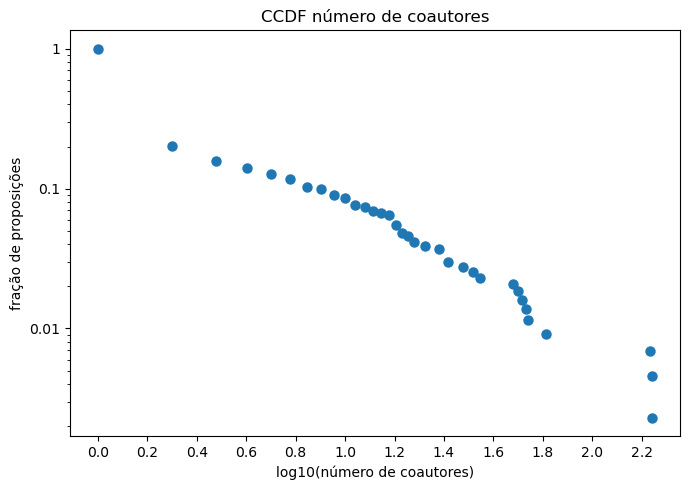

Proposições: 435
Min autores: 1
Max autores: 175
Média autores: 4.35632183908046

CCDF por limiar de coautores:
> 20 autores: 17 proposições (0.039080)
> 100 autores: 3 proposições (0.006897)
> 200 autores: 0 proposições (0.000000)


In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FuncFormatter, LogLocator

# =========================
# CONFIG
# =========================
CSV_PATH = "../data/authors_info.csv"
PROPOSAL_COL = "idProposicao"
AUTHOR_COL = "idAutor"
TYPE_COL = "codTipoAutor"

FILTER_TIPO_AUTOR = 10000  # None para não filtrar

# =========================
# LOAD + PREP
# =========================
df = pd.read_csv(CSV_PATH)

if FILTER_TIPO_AUTOR is not None and TYPE_COL in df.columns:
    df = df[df[TYPE_COL] == FILTER_TIPO_AUTOR].copy()

df = df.drop_duplicates(subset=[PROPOSAL_COL, AUTHOR_COL])

authors_per_prop = df.groupby(PROPOSAL_COL)[AUTHOR_COL].nunique()
authors_per_prop = authors_per_prop[authors_per_prop > 0]

counts = authors_per_prop.values  # n_autores por proposição

# =========================
# CCDF (em valores originais)
# =========================
x = np.sort(np.unique(counts))
ccdf = np.array([(counts >= xi).mean() for xi in x])  # fração em [0,1]

# =========================
# TRANSFORM: eixo X em log10 e linear
# =========================
x_log10 = np.log10(x)

# =========================
# PLOT
# =========================
plt.figure(figsize=(7, 5))
plt.scatter(x_log10, ccdf, linewidth=1.5)

# eixo X agora é linear (em log10), então ticks 1.0, 1.1, 1.2 ficam igualmente espaçados
plt.gca().xaxis.set_major_locator(MultipleLocator(0.2))
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda v, p: f"{v:.1f}"))

# eixo Y continua logarítmico, mas rotulado com valor real (1, 0.1, 0.01, ...)
plt.yscale("log")
plt.gca().yaxis.set_major_locator(LogLocator(base=10))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda v, p: f"{v:.2g}" if v > 0 else ""))

plt.xlabel("log10(número de coautores)")
plt.ylabel("fração de proposições")
plt.title("CCDF número de coautores")
plt.tight_layout()
plt.show()

# =========================
# PRINTS
# =========================
print("Proposições:", len(authors_per_prop))
print("Min autores:", int(np.min(counts)))
print("Max autores:", int(np.max(counts)))
print("Média autores:", float(np.mean(counts)))

thresholds = [20, 100, 200]

print("\nCCDF por limiar de coautores:")
for t in thresholds:
    n_props = np.sum(counts > t)
    frac = n_props / len(counts)
    print(f"> {t} autores: {n_props} proposições ({frac:.6f})")



In [68]:
import pandas as pd
from itertools import combinations

AUTHORS_PATH = "../data/authors_info.csv"
PROPOSALS_PATH = "../data/proposals_info.csv"  # opcional, só para imprimir info extra se existir

a = pd.read_csv(AUTHORS_PATH)

# Segurança: garante tipos
a["idProposicao"] = pd.to_numeric(a["idProposicao"], errors="coerce").astype("Int64")
a["idAutor"] = pd.to_numeric(a["idAutor"], errors="coerce").astype("Int64")
a = a.dropna(subset=["idProposicao", "idAutor"]).copy()
a["idProposicao"] = a["idProposicao"].astype(int)
a["idAutor"] = a["idAutor"].astype(int)

# Conta autores únicos por proposição
counts = a.groupby("idProposicao")["idAutor"].nunique().sort_values(ascending=False)

top3 = counts.head(3)
top_ids = top3.index.tolist()

print("\nTop 3 proposições por número de autores:")
for pid, n in top3.items():
    print(f"  idProposicao={pid}  n_autores={n}")

# Conjuntos de autores
authors_sets = {pid: set(a.loc[a["idProposicao"] == pid, "idAutor"].unique()) for pid in top_ids}

# Checar interseções par a par
print("\nInterseções de autores entre as 3 proposições:")
any_overlap = False
for p1, p2 in combinations(top_ids, 2):
    inter = authors_sets[p1].intersection(authors_sets[p2])
    print(f"  {p1} ∩ {p2}: {len(inter)} autores em comum")
    if len(inter) > 0:
        any_overlap = True

if not any_overlap:
    print("\nResultado: não há interseção de autores entre as 3 proposições (conjuntos disjuntos).")
else:
    print("\nResultado: há interseção entre pelo menos um par (não são disjuntas).")

# Opcional: estimar quantos pares cada proposição gera e quantos pares seriam no total se disjuntas
def nC2(n: int) -> int:
    return n * (n - 1) // 2

print("\nPares (arestas de coautoria) gerados por proposição (nC2):")
total_pairs = 0
for pid in top_ids:
    n = len(authors_sets[pid])
    pairs = nC2(n)
    total_pairs += pairs
    print(f"  idProposicao={pid}  n={n}  nC2={pairs}")

print(f"\nTotal nC2 somado (sem considerar sobreposição de pares com outras proposições): {total_pairs}")

# Extra opcional: imprimir metadados das proposições, se proposals_info.csv existir
try:
    p = pd.read_csv(PROPOSALS_PATH)
    if "id" in p.columns:
        p["id"] = pd.to_numeric(p["id"], errors="coerce").astype("Int64")
        p = p.dropna(subset=["id"]).copy()
        p["id"] = p["id"].astype(int)
        print("\nMetadados (proposals_info) das top 3, se disponíveis:")
        cols = [c for c in ["id", "siglaTipo", "numero", "ano", "resultado_votacao", "ultimoStatus_descricaoSituacao"] if c in p.columns]
        print(p[p["id"].isin(top_ids)][cols].to_string(index=False))
except FileNotFoundError:
    pass



Top 3 proposições por número de autores:
  idProposicao=2301088  n_autores=175
  idProposicao=2282791  n_autores=174
  idProposicao=2336481  n_autores=171

Interseções de autores entre as 3 proposições:
  2301088 ∩ 2282791: 54 autores em comum
  2301088 ∩ 2336481: 68 autores em comum
  2282791 ∩ 2336481: 45 autores em comum

Resultado: há interseção entre pelo menos um par (não são disjuntas).

Pares (arestas de coautoria) gerados por proposição (nC2):
  idProposicao=2301088  n=175  nC2=15225
  idProposicao=2282791  n=174  nC2=15051
  idProposicao=2336481  n=171  nC2=14535

Total nC2 somado (sem considerar sobreposição de pares com outras proposições): 44811

Metadados (proposals_info) das top 3, se disponíveis:
     id siglaTipo  numero  ano resultado_votacao ultimoStatus_descricaoSituacao
2282791       PEC      10 2021          aprovada Transformado em Norma Jurídica
2301088       PEC      32 2021          aprovada Transformado em Norma Jurídica
2336481       PEC      26 2022       

In [70]:
import pandas as pd
import numpy as np
from itertools import combinations
from collections import Counter

CSV_PATH = "../data/authors_info.csv"
PROPOSAL_COL = "idProposicao"
AUTHOR_COL = "idAutor"
TYPE_COL = "codTipoAutor"
FILTER_TIPO_AUTOR = 10000  # None para não filtrar

# =========================
# LOAD + FILTER
# =========================
df = pd.read_csv(CSV_PATH)

if FILTER_TIPO_AUTOR is not None and TYPE_COL in df.columns:
    df = df[df[TYPE_COL] == FILTER_TIPO_AUTOR].copy()

df = df.drop_duplicates(subset=[PROPOSAL_COL, AUTHOR_COL])

# =========================
# k_p por proposição
# =========================
k_by_prop = df.groupby(PROPOSAL_COL)[AUTHOR_COL].nunique()

# proposições que efetivamente geram arestas: k>=2
k_edges = k_by_prop[k_by_prop >= 2].copy()

print(f"Total de proposições no arquivo (k>=1): {int((k_by_prop>=1).sum())}")
print(f"Proposições que geram arestas (k>=2): {len(k_edges)}")

# =========================
# (1) Limite superior somando C(k,2)
# =========================
upper_sum_pairs = int(((k_edges * (k_edges - 1)) // 2).sum())
print(f"Soma de C(k,2) nas proposições k>=2 (conta repetição entre proposições): {upper_sum_pairs}")

# =========================
# (2) Arestas únicas reais: união dos pares (u,v)
# =========================
# Atenção: isso pode ser pesado se houver proposições com k muito grande.
# Mas com ~88 proposições, tende a ser ok.

unique_edges = set()
edge_multiplicity = Counter()  # quantas proposições geraram cada par (opcional)

for prop_id, group in df.groupby(PROPOSAL_COL):
    authors = group[AUTHOR_COL].unique()
    if len(authors) < 2:
        continue

    authors = np.sort(authors)  # garante ordem consistente
    for u, v in combinations(authors, 2):
        unique_edges.add((u, v))
        edge_multiplicity[(u, v)] += 1

print(f"Arestas únicas (pares distintos) na rede: {len(unique_edges)}")

# =========================
# Extras úteis
# =========================
if len(k_edges) > 0:
    avg_pairs_per_prop = upper_sum_pairs / len(k_edges)
    print(f"Média de C(k,2) por proposição (k>=2): {avg_pairs_per_prop:.2f}")

# quanto a repetição “reduz” em relação ao limite superior
# (se muitas proposições compartilham os mesmos pares, upper_sum_pairs >> unique_edges)
if len(unique_edges) > 0:
    redundancy_factor = upper_sum_pairs / len(unique_edges)
    print(f"Fator de redundância = sum C(k,2) / arestas únicas: {redundancy_factor:.3f}")

# distribuição: quantas proposições geram o mesmo par
# ex: quantos pares aparecem em 1, 2, 3... proposições
mult_counts = Counter(edge_multiplicity.values())
top_mult = sorted(mult_counts.items())[:10]
print("Distribuição de multiplicidade (aparições do par -> quantidade de pares) [primeiros 10]:")
for m, c in top_mult:
    print(f"  {m} -> {c}")

# pares mais repetidos
print("\nTop 10 pares mais repetidos (par -> #proposições em que coautoraram):")
for (u, v), c in edge_multiplicity.most_common(10):
    print(f"  ({u}, {v}) -> {c}")


Total de proposições no arquivo (k>=1): 435
Proposições que geram arestas (k>=2): 88
Soma de C(k,2) nas proposições k>=2 (conta repetição entre proposições): 58769
Arestas únicas (pares distintos) na rede: 45177
Média de C(k,2) por proposição (k>=2): 667.83
Fator de redundância = sum C(k,2) / arestas únicas: 1.301
Distribuição de multiplicidade (aparições do par -> quantidade de pares) [primeiros 10]:
  1 -> 37821
  2 -> 5380
  3 -> 591
  4 -> 231
  5 -> 287
  6 -> 288
  7 -> 357
  8 -> 184
  9 -> 28
  10 -> 6

Top 10 pares mais repetidos (par -> #proposições em que coautoraram):
  (74398, 160575) -> 12
  (178857, 204503) -> 11
  (73701, 160575) -> 11
  (160575, 204467) -> 11
  (73701, 74398) -> 10
  (141488, 160575) -> 10
  (160575, 178925) -> 10
  (160575, 204428) -> 10
  (160575, 204503) -> 10
  (204453, 204467) -> 10


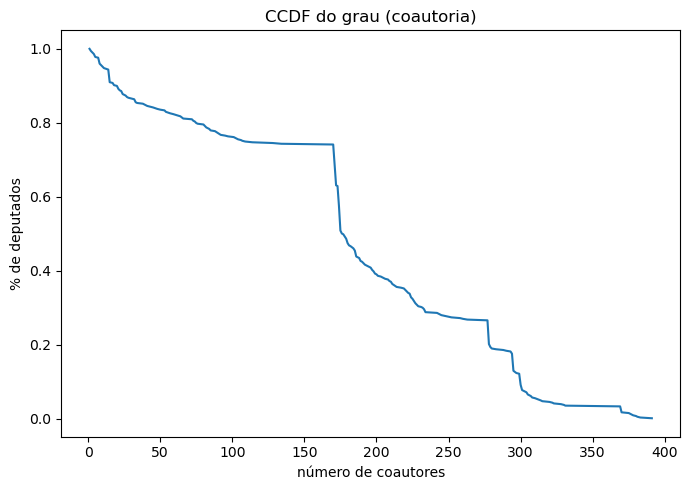

In [72]:
import numpy as np
import matplotlib.pyplot as plt

def plot_ccdf_degree(G):
    
    deg = np.array([d for _, d in G.degree()], dtype=float)
    deg = deg[deg > 0]  # remove isolados para fazer sentido em log

    x = np.sort(np.unique(deg))
    ccdf = np.array([(deg >= xi).mean() for xi in x])  # % de deputados

    plt.figure(figsize=(7, 5))
    plt.plot(x, ccdf)  
    plt.xlabel("número de coautores")
    plt.ylabel("% de deputados")
    plt.title("CCDF do grau (coautoria)")
    plt.tight_layout()
    plt.show()

plot_ccdf_degree(G)


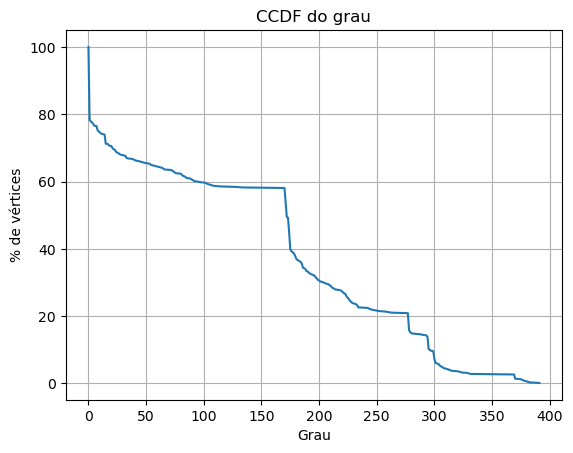

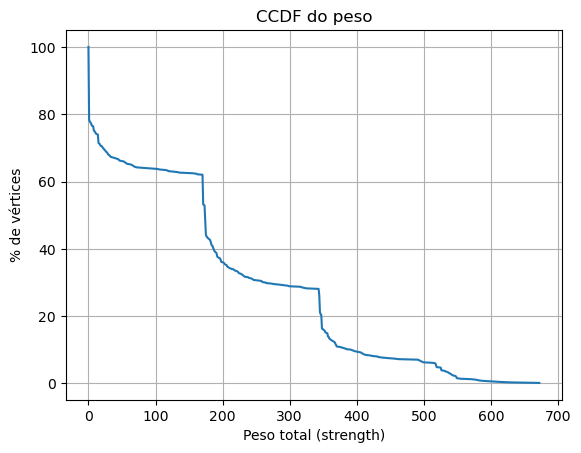

In [74]:
degrees = np.array([d for _, d in G.degree()])

x_deg = np.sort(np.unique(degrees))
ccdf_deg = np.array([(degrees >= xi).mean() for xi in x_deg]) * 100

plt.figure()
plt.plot(x_deg, ccdf_deg)
plt.xlabel("Grau")
plt.ylabel("% de vértices")
plt.title("CCDF do grau")
plt.grid(True)
plt.show()


# Soma dos pesos das arestas por nó
strengths = np.array([
    sum(data.get("weight", 1.0) for _, _, data in G.edges(n, data=True))
    for n in G.nodes()
])

x_str = np.sort(np.unique(strengths))
ccdf_str = np.array([(strengths >= xi).mean() for xi in x_str]) * 100

plt.figure()
plt.plot(x_str, ccdf_str)
plt.xlabel("Peso total (strength)")
plt.ylabel("% de vértices")
plt.title("CCDF do peso")
plt.grid(True)
plt.show()


In [84]:
nodes_in_network = set(int(n) for n in G.nodes() if G.degree(n) > 0)
DEPUTIES_PATH = "../data/deputies_info.csv"
# =========================
# Carregar deputados
# =========================
d = pd.read_csv(DEPUTIES_PATH)

# normalizar
d["index"] = pd.to_numeric(d["index"], errors="coerce").astype("Int64")
d = d.dropna(subset=["index"]).copy()
d["index"] = d["index"].astype(int)

# =========================
# Filtrar PT
# =========================
pt = d[d["party"] == "PT"]

pt_in_network = pt[pt["index"].isin(nodes_in_network)]

# =========================
# Resultados
# =========================
print("\n===== DEPUTADOS DO PT NA REDE =====\n")
print(f"Deputados do PT no CSV: {len(pt)}")
print(f"Deputados do PT presentes na rede (grau > 0): {len(pt_in_network)}")

# opcional: listar ids ou nomes
#print(pt_in_network[["id", "nome"]].to_string(index=False))



===== DEPUTADOS DO PT NA REDE =====

Deputados do PT no CSV: 63
Deputados do PT presentes na rede (grau > 0): 57


In [39]:
from __future__ import annotations

import math
from collections import Counter, defaultdict

import networkx as nx

# Opcional, mas útil para métricas de concordância
try:
    from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
    SKLEARN_OK = True
except Exception:
    SKLEARN_OK = False

def safe_str(x):
    return None if x is None else str(x)

def community_stats_by_party(G: nx.Graph, node_to_comm: dict, party_attr: str = "party"):
    # comunidade -> contagem por partido
    comm_party_counts = defaultdict(Counter)
    comm_sizes = Counter()

    for n in G.nodes():
        c = node_to_comm.get(n)
        if c is None:
            continue
        p = safe_str(G.nodes[n].get(party_attr))
        comm_party_counts[c][p] += 1
        comm_sizes[c] += 1

    # estatísticas por comunidade
    rows = []
    for c, size in comm_sizes.items():
        counts = comm_party_counts[c]
        if size == 0:
            continue

        top_party, top_count = counts.most_common(1)[0]
        purity = top_count / size

        # entropia de Shannon da distribuição de partido na comunidade
        # (0 = totalmente homogênea; maior = mais misturada)
        ent = 0.0
        for party, k in counts.items():
            if k == 0:
                continue
            p = k / size
            ent -= p * math.log(p, 2)

        rows.append({
            "community": c,
            "size": size,
            "top_party": top_party,
            "top_share": purity,
            "entropy_party": ent,
            "party_counts": dict(counts),
        })

    # ordenar por tamanho desc
    rows.sort(key=lambda r: r["size"], reverse=True)
    return rows

def main(G: nx.Graph, party_attr: str = "party", weight_attr: str = "weight",
         out_gexf_path: str = "with_louvain.gexf"):

    # 1) Louvain
    # NetworkX tem louvain_communities em versões recentes.
    try:
        from networkx.algorithms.community import louvain_communities
        communities = louvain_communities(G, weight=weight_attr, seed=42)
    except Exception as e:
        raise RuntimeError(
            "Falha ao importar/rodar louvain_communities do NetworkX. "
            "Verifique a versão do networkx (ideal >= 2.8) e dependências."
        ) from e

    # Converter para mapeamento nó -> id da comunidade (int)
    node_to_comm = {}
    for cid, comm in enumerate(communities):
        for n in comm:
            node_to_comm[n] = int(cid)

    # 2) Modularidade (Q) da partição encontrada
    from networkx.algorithms.community.quality import modularity
    Q = modularity(G, communities, weight=weight_attr)

    print(f"Louvain: {len(communities)} comunidades")
    print(f"Modularidade Q (da partição Louvain): {Q:.6f}")

    # 3) Comparar Louvain vs party
    rows = community_stats_by_party(G, node_to_comm, party_attr=party_attr)

    print("\nResumo por comunidade (top 15 por tamanho):")
    for r in rows[:15]:
        print(
            f"  comm={r['community']:>3}  size={r['size']:>4}  "
            f"top_party={r['top_party']}  top_share={r['top_share']:.3f}  "
            f"entropy={r['entropy_party']:.3f}"
        )

    # Métrica global opcional: NMI e ARI entre rótulos Louvain e party (quando party existe)
    parties = []
    comm_labels = []
    for n in G.nodes():
        p = safe_str(G.nodes[n].get(party_attr))
        c = node_to_comm.get(n)
        if p is None or c is None:
            continue
        parties.append(p)
        comm_labels.append(c)

    if SKLEARN_OK and len(parties) > 0:
        nmi = normalized_mutual_info_score(parties, comm_labels)
        ari = adjusted_rand_score(parties, comm_labels)
        print(f"\nConcordância global (party vs Louvain): NMI={nmi:.4f}  ARI={ari:.4f}")
    else:
        if not SKLEARN_OK:
            print("\nsklearn não disponível: pulando NMI/ARI.")
        else:
            print("\nAtributo party ausente para todos ou quase todos os nós: pulando NMI/ARI.")

    # 4) Gravar atributos no grafo para abrir no Gephi
    nx.set_node_attributes(G, node_to_comm, "louvain")

    # Opcional: gravar também o partido normalizado como string, para evitar tipos mistos
    party_norm = {n: safe_str(G.nodes[n].get(party_attr)) for n in G.nodes()}
    nx.set_node_attributes(G, party_norm, party_attr)

    # Opcional: gravar Q em todos os nós (Gephi não lê bem metadados globais)
    nx.set_node_attributes(G, {n: float(Q) for n in G.nodes()}, "louvain_modularity_Q")

    nx.write_gexf(G, out_gexf_path)
    print(f"\nGEXF exportado: {out_gexf_path}")
    print("Atributos adicionados nos nós: 'louvain', 'louvain_modularity_Q' e o atributo de partido normalizado.")

# Exemplo de uso:
# main(G, party_attr="party", weight_attr="weight", out_gexf_path="G_louvain.gexf")


In [40]:
main(G, party_attr="party", weight_attr="weight", out_gexf_path="G_louvain.gexf")

Louvain: 143 comunidades
Modularidade Q (da partição Louvain): 0.328759

Resumo por comunidade (top 15 por tamanho):
  comm=  1  size= 174  top_party=PL  top_share=0.322  entropy=2.823
  comm= 30  size= 114  top_party=MDB  top_share=0.219  entropy=3.485
  comm= 59  size= 112  top_party=PSDB  top_share=0.179  entropy=3.761
  comm= 37  size=  85  top_party=PT  top_share=0.659  entropy=1.830
  comm=  0  size=  14  top_party=  top_share=1.000  entropy=0.000
  comm=  2  size=   1  top_party=  top_share=1.000  entropy=0.000
  comm=  3  size=   1  top_party=MDB  top_share=1.000  entropy=0.000
  comm=  4  size=   1  top_party=PT  top_share=1.000  entropy=0.000
  comm=  5  size=   1  top_party=PSC  top_share=1.000  entropy=0.000
  comm=  6  size=   1  top_party=PSDB  top_share=1.000  entropy=0.000
  comm=  7  size=   1  top_party=PSD  top_share=1.000  entropy=0.000
  comm=  8  size=   1  top_party=UNIÃO  top_share=1.000  entropy=0.000
  comm=  9  size=   1  top_party=PSDB  top_share=1.000  entr

In [43]:
import math
from collections import Counter, defaultdict

import numpy as np

def _is_number(x):
    if x is None:
        return False
    if isinstance(x, (int, float, np.integer, np.floating)) and not (isinstance(x, float) and math.isnan(x)):
        return True
    # tentar converter strings numéricas
    if isinstance(x, str):
        try:
            float(x.replace(",", "."))
            return True
        except Exception:
            return False
    return False

def _to_float(x):
    if x is None:
        return None
    if isinstance(x, (int, float, np.integer, np.floating)):
        if isinstance(x, float) and math.isnan(x):
            return None
        return float(x)
    if isinstance(x, str):
        try:
            return float(x.replace(",", "."))
        except Exception:
            return None
    return None

def _cramers_v_from_contingency(table_2d):
    """
    table_2d: array shape (r, c), aqui c=2 (in/out).
    Retorna Cramér's V.
    """
    X = np.array(table_2d, dtype=float)
    n = X.sum()
    if n <= 0:
        return 0.0

    row_sums = X.sum(axis=1, keepdims=True)
    col_sums = X.sum(axis=0, keepdims=True)
    expected = (row_sums @ col_sums) / n

    # evitar divisão por zero
    with np.errstate(divide="ignore", invalid="ignore"):
        chi2 = np.nansum((X - expected) ** 2 / expected)

    r, c = X.shape
    if r <= 1 or c <= 1:
        return 0.0

    denom = n * (min(r - 1, c - 1))
    if denom <= 0:
        return 0.0
    return float(math.sqrt(chi2 / denom))

def _point_biserial_corr(values, membership01):
    """
    values: lista de floats
    membership01: lista de 0/1 (mesmo tamanho)
    Retorna correlação ponto bisserial (equivalente ao Pearson entre x e indicador binário).
    """
    x = np.array(values, dtype=float)
    y = np.array(membership01, dtype=float)
    if len(x) < 3:
        return 0.0
    if np.all(y == y[0]):
        return 0.0
    if np.std(x) == 0:
        return 0.0
    r = np.corrcoef(x, y)[0, 1]
    if np.isnan(r):
        return 0.0
    return float(abs(r))  # magnitude da associação

def analyze_partition_best_attribute(G, comm_key, exclude_keys=None, min_valid_frac=0.6, top_k_print=10):
    """
    Para cada comunidade, escolhe o atributo de nó com maior associação
    (Cramér's V para categórico; ponto bisserial para numérico)
    entre "estar na comunidade" vs "não estar".
    """
    if exclude_keys is None:
        exclude_keys = set()
    else:
        exclude_keys = set(exclude_keys)

    exclude_keys |= {comm_key, "louvain_modularity_Q", "louvain","newman_modularity_Q"}

    # comunidades existentes
    comm_of = {}
    for n, data in G.nodes(data=True):
        if comm_key in data:
            comm_of[n] = data[comm_key]

    comm_ids = sorted(set(comm_of.values()))
    n_total = len(comm_of)
    if n_total == 0:
        raise ValueError(f"Nenhum nó tem o atributo {comm_key}.")

    # coletar chaves de atributos candidatas
    all_keys = set()
    for n, data in G.nodes(data=True):
        if n not in comm_of:
            continue
        for k in data.keys():
            if k in exclude_keys:
                continue
            all_keys.add(k)

    # pré coletar valores por atributo para acelerar
    attr_values = {k: {} for k in all_keys}  # attr -> {node: value}
    for n, data in G.nodes(data=True):
        if n not in comm_of:
            continue
        for k in all_keys:
            if k in data:
                attr_values[k][n] = data.get(k)

    # análise por comunidade
    results = []
    for cid in comm_ids:
        nodes_in = [n for n in comm_of if comm_of[n] == cid]
        nodes_out = [n for n in comm_of if comm_of[n] != cid]
        size_in = len(nodes_in)
        if size_in == 0:
            continue

        best = None  # (score, attr_name, kind, top_value, top_pct, extra)
        for attr in all_keys:
            vals_map = attr_values[attr]
            # valores válidos entre in e out
            in_vals = []
            out_vals = []
            for n in nodes_in:
                if n in vals_map and vals_map[n] is not None:
                    in_vals.append(vals_map[n])
            for n in nodes_out:
                if n in vals_map and vals_map[n] is not None:
                    out_vals.append(vals_map[n])

            valid = len(in_vals) + len(out_vals)
            if valid == 0:
                continue
            if valid / (len(nodes_in) + len(nodes_out)) < min_valid_frac:
                continue

            # decidir tipo numérico vs categórico
            in_num = sum(_is_number(v) for v in in_vals)
            out_num = sum(_is_number(v) for v in out_vals)
            num_frac = (in_num + out_num) / max(1, valid)

            if num_frac >= 0.9:
                # numérico
                X = []
                Y = []
                for n in nodes_in:
                    if n in vals_map:
                        f = _to_float(vals_map[n])
                        if f is not None:
                            X.append(f)
                            Y.append(1)
                for n in nodes_out:
                    if n in vals_map:
                        f = _to_float(vals_map[n])
                        if f is not None:
                            X.append(f)
                            Y.append(0)

                score = _point_biserial_corr(X, Y)
                kind = "numeric"

                # para reportar, usar média dentro e fora
                x_in = [ _to_float(vals_map[n]) for n in nodes_in if _to_float(vals_map.get(n)) is not None ]
                x_out = [ _to_float(vals_map[n]) for n in nodes_out if _to_float(vals_map.get(n)) is not None ]
                mu_in = float(np.mean(x_in)) if len(x_in) else None
                mu_out = float(np.mean(x_out)) if len(x_out) else None
                top_value = f"mean_in={mu_in:.3g}, mean_out={mu_out:.3g}" if (mu_in is not None and mu_out is not None) else "mean_in/out unavailable"
                top_pct = None

            else:
                # categórico
                # construir contingência: categorias x {in,out}
                counter_in = Counter(str(v) for v in in_vals)
                counter_out = Counter(str(v) for v in out_vals)

                cats = sorted(set(counter_in.keys()) | set(counter_out.keys()))
                if len(cats) <= 1:
                    continue

                table = []
                for c in cats:
                    table.append([counter_in.get(c, 0), counter_out.get(c, 0)])

                score = _cramers_v_from_contingency(table)
                kind = "categorical"

                # reportar categoria mais comum dentro da comunidade e seu percentual interno
                top_cat, top_count = counter_in.most_common(1)[0]
                top_value = top_cat
                top_pct = (top_count / sum(counter_in.values())) * 100.0 if sum(counter_in.values()) > 0 else 0.0

            if best is None or score > best[0]:
                best = (score, attr, kind, top_value, top_pct)

        results.append((cid, size_in, best))

    # ordenar por tamanho desc
    results.sort(key=lambda x: x[1], reverse=True)

    # imprimir
    print(f"{comm_key.capitalize()}, {len(results)} comunidades.")
    print("")
    for cid, size_in, best in results[:top_k_print]:
        if best is None:
            print(f"Comunidade {cid}: sem atributo elegível (dados insuficientes).")
            continue
        score, attr, kind, top_value, top_pct = best
        if kind == "categorical":
            print(f"Comunidade {cid}: Atributo com maior associação: {attr}. {top_value} ({top_pct:.1f}%). V={score:.3f}")
        else:
            print(f"Comunidade {cid}: Atributo com maior associação: {attr}. {top_value}. |r|={score:.3f}")

    return results


# Executar para Louvain
# Ajuste exclude_keys se você tiver colunas que não são atributos substantivos (ex.: "label", "id", "name")
louvain_results = analyze_partition_best_attribute(
    G,
    comm_key="louvain",
    exclude_keys={"id", "name", "label"},
    min_valid_frac=0.6,
    top_k_print=50  # coloque 50 se quiser listar todas
)


Louvain, 143 comunidades.

Comunidade 1: Atributo com maior associação: party. PL (32.2%). V=0.547
Comunidade 30: Atributo com maior associação: party. MDB (21.9%). V=0.422
Comunidade 59: Atributo com maior associação: party. PSDB (17.9%). V=0.467
Comunidade 37: Atributo com maior associação: party. PT (65.9%). V=0.846
Comunidade 0: Atributo com maior associação: education.  (100.0%). V=0.758
Comunidade 2: Atributo com maior associação: region.  (100.0%). V=0.200
Comunidade 3: Atributo com maior associação: uf. RS (100.0%). V=0.160
Comunidade 4: Atributo com maior associação: uf. BA (100.0%). V=0.146
Comunidade 5: Atributo com maior associação: party. PSC (100.0%). V=0.299
Comunidade 6: Atributo com maior associação: party. PSDB (100.0%). V=0.175
Comunidade 7: Atributo com maior associação: uf. PI (100.0%). V=0.275
Comunidade 8: Atributo com maior associação: uf. PI (100.0%). V=0.275
Comunidade 9: Atributo com maior associação: uf. MS (100.0%). V=0.314
Comunidade 10: Atributo com maior

In [86]:
from __future__ import annotations

import math
from collections import Counter, defaultdict
from typing import Dict, Iterable, List, Sequence, Set, Tuple

import numpy as np
import networkx as nx


def _safe_str(x):
    return None if x is None else str(x)


def _global_weighted_degrees(G: nx.Graph, weight: str) -> Dict:
    # grau ponderado global (no grafo inteiro), como no modelo nulo da modularidade
    return dict(G.degree(weight=weight))


def _global_total_weight(G: nx.Graph, weight: str) -> float:
    # para grafo não direcionado, m = soma dos pesos das arestas
    return float(G.size(weight=weight))


def _build_B_subgraph(
    nodes: Sequence,
    A: np.ndarray,
    k_global: Dict,
    m: float,
) -> np.ndarray:
    """
    Constrói a matriz B^g (Newman) para um conjunto de nós 'nodes' (subproblema).
    A é a adjacência ponderada induzida por 'nodes' (matriz densa).
    k_global é o grau ponderado global de cada nó no grafo original.
    m é o peso total do grafo (soma de pesos das arestas).
    """
    n = len(nodes)
    k = np.array([k_global[v] for v in nodes], dtype=float)

    # B = A - (k_i k_j) / (2m)
    B = A - np.outer(k, k) / (2.0 * m)

    # Ajuste do subgrafo: B^g = B - diag(sum_j B_ij)
    row_sums = B.sum(axis=1)
    Bg = B - np.diag(row_sums)

    return Bg


def _leading_eigenvector(B: np.ndarray) -> Tuple[float, np.ndarray]:
    """
    Retorna (lambda_max, v_max) para uma matriz simétrica B.
    Usa eigh (autovalores reais). Para tamanhos moderados é suficiente.
    """
    vals, vecs = np.linalg.eigh(B)
    idx = int(np.argmax(vals))
    return float(vals[idx]), vecs[:, idx]


def _delta_Q(Bg: np.ndarray, s: np.ndarray, m: float) -> float:
    """
    ΔQ = (1/(4m)) s^T Bg s
    """
    return float((s.T @ Bg @ s) / (4.0 * m))


def newman_leading_eigenvector_communities(
    G: nx.Graph,
    weight: str = "weight",
    min_comm_size: int = 1,
) -> List[Set]:
    """
    Implementação recursiva do método espectral de Newman para maximizar modularidade.
    Divide um conjunto de nós em dois se houver ganho positivo de modularidade.

    min_comm_size: impede divisões que gerariam comunidades menores que este tamanho.
    """
    if nx.is_directed(G):
        raise ValueError("Este script espera um grafo não direcionado (nx.Graph).")

    m = _global_total_weight(G, weight=weight)
    if m <= 0:
        # sem arestas (ou pesos zero): cada nó vira uma comunidade
        return [{n} for n in G.nodes()]

    k_global = _global_weighted_degrees(G, weight=weight)

    # fila de conjuntos a avaliar
    pending: List[Set] = [set(G.nodes())]
    final_comms: List[Set] = []

    while pending:
        S = pending.pop()

        # se for pequeno demais para dividir, finalize
        if len(S) < 2 * max(1, min_comm_size):
            final_comms.append(S)
            continue

        nodes = list(S)

        # matriz de adjacência ponderada do subgrafo induzido por S
        A = nx.to_numpy_array(G, nodelist=nodes, weight=weight, dtype=float)

        Bg = _build_B_subgraph(nodes=nodes, A=A, k_global=k_global, m=m)

        lam, v = _leading_eigenvector(Bg)

        # se o maior autovalor não for positivo, não há divisão que aumente Q via este critério
        if lam <= 1e-12:
            final_comms.append(S)
            continue

        # vetor de partição s pela regra do sinal
        s = np.ones(len(nodes), dtype=float)
        s[v < 0] = -1.0

        # evitar partição degenerada (todos do mesmo lado)
        if np.all(s > 0) or np.all(s < 0):
            final_comms.append(S)
            continue

        # construir os dois grupos
        S_pos = {nodes[i] for i in range(len(nodes)) if s[i] > 0}
        S_neg = set(nodes) - S_pos

        # respeitar tamanho mínimo
        if len(S_pos) < min_comm_size or len(S_neg) < min_comm_size:
            final_comms.append(S)
            continue

        dQ = _delta_Q(Bg, s, m)

        # só divide se houver ganho positivo de modularidade
        if dQ > 1e-12:
            pending.append(S_pos)
            pending.append(S_neg)
        else:
            final_comms.append(S)

    return final_comms


def summarize_by_party(
    G: nx.Graph,
    node_to_comm: Dict,
    party_attr: str = "party",
    top_k: int = 15,
):
    comm_counts = defaultdict(Counter)
    comm_sizes = Counter()

    for n in G.nodes():
        c = node_to_comm.get(n)
        p = _safe_str(G.nodes[n].get(party_attr))
        comm_counts[c][p] += 1
        comm_sizes[c] += 1

    rows = []
    for c, size in comm_sizes.items():
        top_party, top_count = comm_counts[c].most_common(1)[0]
        top_share = top_count / size

        ent = 0.0
        for _, k in comm_counts[c].items():
            if k <= 0:
                continue
            pr = k / size
            ent -= pr * math.log(pr, 2)

        rows.append((c, size, top_party, top_share, ent))

    rows.sort(key=lambda x: x[1], reverse=True)

    print(f"\nResumo (top {top_k}) comunidade vs party:")
    for c, size, top_party, top_share, ent in rows[:top_k]:
        print(
            f"  comm={int(c):>3}  size={size:>4}  top_party={top_party}  "
            f"top_share={top_share:.3f}  entropy={ent:.3f}"
        )


def run_newman_and_export(
    G: nx.Graph,
    weight_attr: str = "weight",
    party_attr: str = "party",
    out_gexf_path: str = "G_newman.gexf",
    min_comm_size: int = 1,
):
    # garantir que todas as arestas têm peso
    for _, _, data in G.edges(data=True):
        data.setdefault(weight_attr, 1.0)

    communities = newman_leading_eigenvector_communities(
        G, weight=weight_attr, min_comm_size=min_comm_size
    )

    from networkx.algorithms.community.quality import modularity
    Q = modularity(G, communities, weight=weight_attr)

    print(f"Newman (spectral): {len(communities)} comunidades")
    print(f"Modularidade Q (partição Newman): {Q:.6f}")

    # mapear nó -> id de comunidade
    node_to_comm = {}
    for cid, comm in enumerate(communities):
        for n in comm:
            node_to_comm[n] = int(cid)

    # anexar atributos para Gephi
    nx.set_node_attributes(G, node_to_comm, "newman")
    nx.set_node_attributes(G, {n: float(Q) for n in G.nodes()}, "newman_modularity_Q")

    # normalizar party como string para evitar tipos mistos no Gephi
    party_norm = {n: _safe_str(G.nodes[n].get(party_attr)) for n in G.nodes()}
    nx.set_node_attributes(G, party_norm, party_attr)

    nx.write_gexf(G, out_gexf_path)
    print(f"GEXF exportado: {out_gexf_path}")
    print("Colunas de nó adicionadas: 'newman' e 'newman_modularity_Q'.")

    # opcional: resumo por party
    summarize_by_party(G, node_to_comm, party_attr=party_attr)


# Uso:
# run_newman_and_export(G, weight_attr="weight", party_attr="party", out_gexf_path="G_newman.gexf", min_comm_size=1)


In [88]:
run_newman_and_export(G, weight_attr="weight", party_attr="party", out_gexf_path="G_newman.gexf", min_comm_size=1)

Newman (spectral): 8 comunidades
Modularidade Q (partição Newman): 0.322626
GEXF exportado: G_newman.gexf
Colunas de nó adicionadas: 'newman' e 'newman_modularity_Q'.

Resumo (top 15) comunidade vs party:
  comm=  7  size= 282  top_party=UNIÃO  top_share=0.156  entropy=3.954
  comm=  6  size= 182  top_party=PL  top_share=0.308  entropy=2.940
  comm=  0  size=  92  top_party=PT  top_share=0.609  entropy=2.196
  comm=  1  size=  64  top_party=PSDB  top_share=0.281  entropy=3.316
  comm=  2  size=  14  top_party=  top_share=1.000  entropy=0.000
  comm=  4  size=   1  top_party=PSB  top_share=1.000  entropy=0.000
  comm=  5  size=   1  top_party=  top_share=1.000  entropy=0.000
  comm=  3  size=   1  top_party=  top_share=1.000  entropy=0.000


In [90]:
# Executar para Newman
newman_results = analyze_partition_best_attribute(
    G,
    comm_key="newman",
    exclude_keys={"id", "name", "label"},
    min_valid_frac=0.6,
    top_k_print=50  # coloque 50 se quiser listar todas
)


Newman, 8 comunidades.

Comunidade 7: Atributo com maior associação: party. UNIÃO (15.6%). V=0.453
Comunidade 6: Atributo com maior associação: party. PL (30.8%). V=0.534
Comunidade 0: Atributo com maior associação: party. PT (60.9%). V=0.812
Comunidade 1: Atributo com maior associação: party. PSDB (28.1%). V=0.436
Comunidade 2: Atributo com maior associação: education.  (100.0%). V=0.758
Comunidade 3: Atributo com maior associação: region.  (100.0%). V=0.200
Comunidade 4: Atributo com maior associação: uf. PE (100.0%). V=0.182
Comunidade 5: Atributo com maior associação: region.  (100.0%). V=0.200


In [96]:
import networkx as nx
from collections import defaultdict

def _get_party_attr_name(G):
    for _, data in G.nodes(data=True):
        for cand in ["party", "siglaPartido", "partido"]:
            if cand in data:
                return cand
    return None

def modularity_by_party(G, exclude_nodes=None):
    """
    Calcula a modularidade da partição definida pelo atributo de partido.
    exclude_nodes: conjunto opcional de nós a excluir antes do cálculo.
    """
    H = G
    if exclude_nodes is not None and len(exclude_nodes) > 0:
        H = G.copy()
        H.remove_nodes_from([n for n in exclude_nodes if n in H])

    party_attr = _get_party_attr_name(H)
    if party_attr is None:
        raise ValueError("Não encontrei atributo de partido no grafo (party/siglaPartido/partido).")

    # construir partição: lista de conjuntos de nós
    buckets = defaultdict(set)
    missing = 0
    for n, data in H.nodes(data=True):
        p = data.get(party_attr, None)
        if p is None or str(p).strip() == "" or str(p).lower() == "nan":
            p = "__MISSING__"
            missing += 1
        buckets[str(p)].add(n)

    communities = list(buckets.values())

    Q = nx.algorithms.community.quality.modularity(H, communities, weight="weight")
    return Q, party_attr, len(communities), missing, H.number_of_nodes(), H.number_of_edges()


# =========================
# 1) Modularidade por partido na rede inteira
# =========================
Q_all, party_attr, k_parts_all, n_missing_all, n_nodes_all, n_edges_all = modularity_by_party(G)

print("\n===== MODULARIDADE POR PARTIDO (REDE INTEIRA) =====")
print(f"Atributo usado: {party_attr}")
print(f"Nós: {n_nodes_all} | Arestas: {n_edges_all}")
print(f"N grupos (partidos + missing): {k_parts_all} | nós sem partido: {n_missing_all}")
print(f"Modularidade Q: {Q_all:.6f}")


# =========================
# 2) Excluir grau 0 e restringir à maior componente conexa, modularidade por partido
# =========================
deg0 = {n for n in G.nodes() if G.degree(n) == 0}
H = G.copy()
H.remove_nodes_from(list(deg0))

if H.number_of_nodes() == 0:
    raise ValueError("Após remover nós de grau 0, o grafo ficou vazio.")

# maior componente conexa (para grafo não direcionado)
gcc_nodes = max(nx.connected_components(H), key=len)
H_gcc = H.subgraph(gcc_nodes).copy()

Q_gcc, party_attr2, k_parts_gcc, n_missing_gcc, n_nodes_gcc, n_edges_gcc = modularity_by_party(H_gcc)

print("\n===== MODULARIDADE POR PARTIDO (SEM GRAU 0 + MAIOR COMPONENTE) =====")
print(f"Atributo usado: {party_attr2}")
print(f"Nós: {n_nodes_gcc} | Arestas: {n_edges_gcc}")
print(f"N grupos (partidos + missing): {k_parts_gcc} | nós sem partido: {n_missing_gcc}")
print(f"Modularidade Q: {Q_gcc:.6f}")



===== MODULARIDADE POR PARTIDO (REDE INTEIRA) =====
Atributo usado: party
Nós: 637 | Arestas: 45177
N grupos (partidos + missing): 24 | nós sem partido: 24
Modularidade Q: 0.135962

===== MODULARIDADE POR PARTIDO (SEM GRAU 0 + MAIOR COMPONENTE) =====
Atributo usado: party
Nós: 499 | Arestas: 45177
N grupos (partidos + missing): 24 | nós sem partido: 20
Modularidade Q: 0.135962
